In [18]:
from google.colab import files
uploaded = files.upload()




Saving glacial_lake_dataset.zip to glacial_lake_dataset (3).zip


In [28]:
import zipfile


import os

for file in os.listdir("glacial_data"):
    if file.endswith(".png"):
        print(file)




lake1_mask.png
lake4.png
lake2_mask.png
lake1.png
lake4_mask.png
lake3.png
lake2.png
lake3_mask.png
lake5_mask.png
lake5.png


In [31]:
import cv2
import numpy as np
import os

image_dir = "glacial_data"
mask_dir = "glacial_data"

# Get only image files (not masks)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png") and "_mask" not in f])
mask_files = [f.replace(".png", "_mask.png") for f in image_files]

# Confirm matching
print("Found image-mask pairs:", len(image_files))

X, Y = [], []

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    img = cv2.imread(img_path) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = np.expand_dims(mask, axis=-1)  # (128,128,1)

    X.append(img)
    Y.append(mask)

X = np.array(X)
Y = np.array(Y)

# Use all 5 for both training and test (for now)
X_train, X_test = X, X
Y_train, Y_test = Y, Y

print("✅ Loaded", X.shape[0], "image-mask pairs. Image shape:", X.shape[1:])




Found image-mask pairs: 5
✅ Loaded 5 image-mask pairs. Image shape: (128, 128, 3)


In [32]:
import tensorflow as tf

def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(d3)

    return tf.keras.Model(inputs, outputs)

# Build and compile
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_4[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_17[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_18[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │  1,179,904 │ concatenate_2[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_19[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    131,200 │ conv2d_20[0][0] 

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=15, batch_size=2)



Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9138 - loss: 0.6441 - val_accuracy: 0.7648 - val_loss: 0.5070
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8001 - loss: 0.5874 - val_accuracy: 0.7648 - val_loss: 0.4852
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8021 - loss: 0.4287 - val_accuracy: 0.7648 - val_loss: 0.4596
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7979 - loss: 0.4239 - val_accuracy: 0.7648 - val_loss: 0.4207
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7980 - loss: 0.3811 - val_accuracy: 0.7648 - val_loss: 0.3862
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8021 - loss: 0.3342 - val_accuracy: 0.7648 - val_loss: 0.3211
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7937 - loss: 0.2858 - val_accuracy: 0.9589 - val_loss: 0.2407
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9635 - loss: 0.2071 - val_accuracy: 0.9722 - val_loss: 0.1701
Epoch 9/15
2/2 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


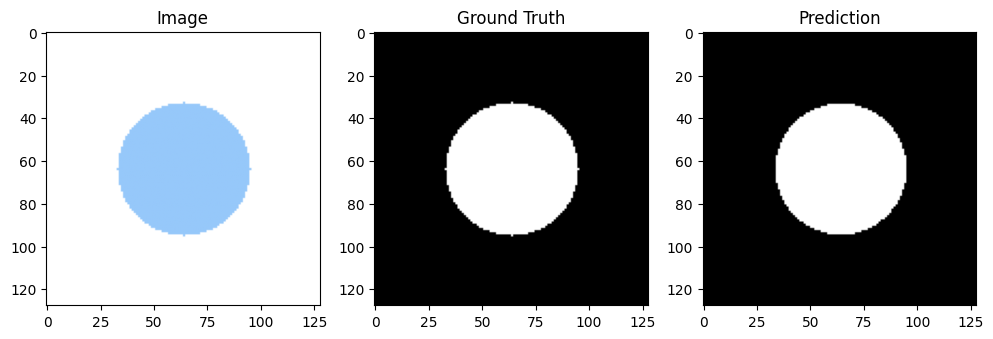

In [34]:
import matplotlib.pyplot as plt

i = 0  # Change index to see different examples
pred = model.predict(np.expand_dims(X_test[i], axis=0))[0, :, :, 0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(X_test[i])

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(Y_test[i].squeeze(), cmap='gray')

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred > 0.5, cmap='gray')  # Thresholded

plt.show()



In [38]:
from google.colab import files
uploaded = files.upload()  # Upload glacial_lake_2018.tif and glacial_lake_2024.tif




Saving glacial_lake_2018.tif to glacial_lake_2018 (1).tif
Saving glacial_lake_2024.tif to glacial_lake_2024.tif


In [39]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 115.7 MB/s eta 0:00:00


In [40]:
import rasterio
import numpy as np
import cv2

def load_tif_image(filename, size=(128, 128)):
    with rasterio.open(filename) as src:
        img = src.read([1, 2, 3])  # Read RGB bands (B4, B3, B2)
        img = np.transpose(img, (1, 2, 0))  # Channels last
        img = cv2.resize(img, size)  # Resize to 128x128
        img = img.astype(np.float32) / 255.0  # Normalize
    return img

img_2018 = load_tif_image("glacial_lake_2018.tif")
img_2024 = load_tif_image("glacial_lake_2024.tif")

print("Image shape:", img_2018.shape)


Image shape: (128, 128, 3)


In [41]:
pred_2018 = model.predict(np.expand_dims(img_2018, axis=0))[0, :, :, 0]
pred_2024 = model.predict(np.expand_dims(img_2024, axis=0))[0, :, :, 0]

# Threshold to get binary lake masks
mask_2018 = (pred_2018 > 0.5).astype(np.uint8)
mask_2024 = (pred_2024 > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


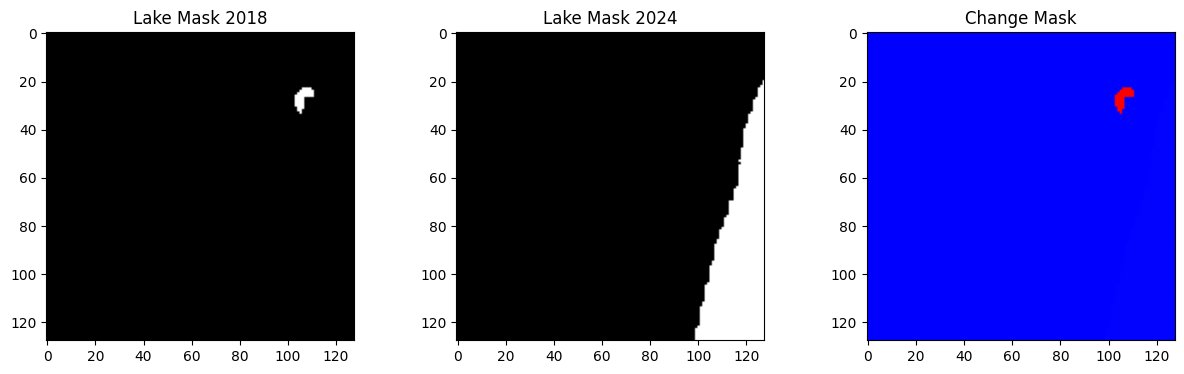

In [42]:
change_mask = mask_2024 - mask_2018  # 1 = lake expansion, -1 = shrinkage

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Lake Mask 2018")
plt.imshow(mask_2018, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Lake Mask 2024")
plt.imshow(mask_2024, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Change Mask")
plt.imshow(change_mask, cmap="bwr")  # red=loss, blue=gain

plt.show()


In [43]:
# Count pixels classified as lake
pixels_2018 = np.sum(mask_2018)
pixels_2024 = np.sum(mask_2024)

print("Lake Pixels in 2018:", pixels_2018)
print("Lake Pixels in 2024:", pixels_2024)


Lake Pixels in 2018: 47
Lake Pixels in 2024: 1714


In [44]:
pixel_area_m2 = 10 * 10  # 10m x 10m per pixel = 100 m²
pixel_area_km2 = pixel_area_m2 / 1e6  # Convert to km²

area_2018_km2 = pixels_2018 * pixel_area_km2
area_2024_km2 = pixels_2024 * pixel_area_km2
area_change = area_2024_km2 - area_2018_km2

print(f"Lake Area in 2018: {area_2018_km2:.4f} sq.km")
print(f"Lake Area in 2024: {area_2024_km2:.4f} sq.km")
print(f"Net Change: {area_change:+.4f} sq.km")


Lake Area in 2018: 0.0047 sq.km
Lake Area in 2024: 0.1714 sq.km
Net Change: +0.1667 sq.km
